In [5]:
import torch
import pandas as pd

# nlp library of Pytorch
from torchtext import data
import torch.optim as optim
import torch
import pandas as pd
import torch.nn as nn
# nlp library of Pytorch
from torchtext import data
import torch.optim as optim
import math
from tempfile import TemporaryDirectory
from typing import Tuple
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn import metrics
from underthesea import text_normalize,word_tokenize, ner
import warnings as wrn
wrn.filterwarnings('ignore')

In [4]:
!pip install underthesea

     |████████████████████████████████| 19.2 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 599 kB 51.9 MB/s eta 0:00:01
     |████████████████████████████████| 966 kB 34.3 MB/s eta 0:00:01


In [6]:
data_ = pd.read_csv('/kaggle/input/text-clone-dataset-foody/preprocess_data_new.csv')
print(f"Shape: {data_.shape}")
data_.head(5)

Shape: (47998, 3)


,Unnamed: 0,text,label
0,0,tạm tạm thái độ phục vụ nhân viên quán kêu tô...,0
1,1,không gian rộng rãi sang trọng hệ thống kỹ t...,0
2,2,chân cầu chuỗi quán ăn vặt món đa dạng yaourt...,0
3,3,khung cảnh mát mẻ đặc sắc giá vé trọn gói ba...,0
4,4,hôm nay sinh nhật gọi món cơm thập cẩm sợi tó...,0


**Import dữ liệu**

In [7]:
def tokenize_vie(text):
    text = text_normalize(text)
    return word_tokenize(text)

In [44]:
TEXT = data.Field(tokenize = tokenize_vie,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [("id",None),("text",TEXT),("label",LABEL)]
training_data = data.TabularDataset(path="/kaggle/input/text-clone-dataset-foody/preprocess_data_new.csv",
                                    format="csv",
                                    fields=fields,
                                    skip_header=True
                                   )

# train_data, valid_data = training_data.split(split_ratio=0.8,)

train_data, all_data = training_data.split(split_ratio=0.7,)
val_data, test_data = all_data.split(split_ratio=0.5,)

**Xây dụng từ vựng**

In [45]:
TEXT.build_vocab(train_data,min_freq=3)
LABEL.build_vocab(train_data)

In [47]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1})


In [48]:
print(len(TEXT.vocab))
print(TEXT)
print(vars(training_data.examples[5000]))
print("Size of text vocab:",(TEXT.vocab[1842]))
print("Size of label vocab:",LABEL)
# TEXT.vocab.freqs.most_common(10)

13081
{'text': ['uống', 'ngon', 'nghiện', 'hôm', 'uống', 'hôm', 'cốc', 'hôm', 'hẳn', 'cốc', 'nhân viên', 'uống', 'quán', 'sạch', 'view', 'hơi', 'nhở', 'nhg', 'bắt', 'mắt'], 'label': '0'}
Size of text vocab: 0
Size of label vocab: <torchtext.data.field.LabelField object at 0x76cfee9bc1d0>


**Đưa các câu cùng độ dài vào 1 batch**

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
train_iterator,val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x:len(x.text),
    sort_within_batch = True,
)

**Define model LSTM**

In [97]:
class LSTMNet(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers):
        
        super(LSTMNet,self).__init__()
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            batch_first = True
                           )
        
        self.batch_norm_1 =  nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim ,output_dim)
        self.batch_norm_2 =  nn.BatchNorm1d(output_dim)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        h = hidden_state[-1,:,:]
        h = F.relu(h)
        h = self.batch_norm_1(h)
        h = self.fc(h)
        h = self.sigmoid(h)
        return h
    
SIZE_OF_VOCAB = len(TEXT.vocab)
EMBEDDING_DIM = 32
NUM_HIDDEN_NODES = 32
NUM_OUTPUT_NODES = 1
NUM_LAYERS = 2
model = LSTMNet(SIZE_OF_VOCAB,
                EMBEDDING_DIM,
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
               )

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.BCELoss().to(device)
total_para = sum(p.numel() for p in model.parameters())
print(total_para)

435587


**Train model LSTM**

In [98]:
epochs_time = torch.Tensor([])

train_loss_list, val_loss_list, test_loss_list = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_loss, epoch_val_loss, epoch_test_loss = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_f1, val_f1, test_f1 = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_f1, epoch_val_f1, epoch_test_f1 = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_acc, val_acc, test_acc = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_acc, epoch_val_acc, epoch_test_acc = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_precision, val_precision, test_precision = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_precision, epoch_val_precision, epoch_test_precision = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_recall, val_recall, test_recall = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_recall, epoch_val_recall, epoch_test_recall = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

for epoch in range(100):
    model.train()
    
    # Start
    for batch in train_iterator:      
        optimizer.zero_grad()
        text,text_lengths = batch.text
        
        len_all = len(text_lengths)        
        fake_text = []
        fake_text_lengths = []
        fake_label = []
        for i in range(0,len_all):
            if text_lengths[i] != 0:
                fake_text.append(text[i].tolist())
                fake_text_lengths.append(text_lengths[i].item() )
                fake_label.append(batch.label[i].item())
        text = torch.Tensor(fake_text).long().to(device)
        text_lengths = torch.Tensor(fake_text_lengths).long().to(device)
        batch.label = torch.Tensor(fake_label).to(device)

        predictions = model(text,text_lengths).squeeze()
        
        loss = criterion(predictions,batch.label)

        train_loss_list = torch.cat((train_loss_list, torch.Tensor([loss.item()])))
        
        train_pred_round = torch.round(torch.clone(predictions)).cpu().detach().numpy()
        train_ground_truth = torch.clone(batch.label).cpu().detach().numpy()
    
        f1 = f1_score(train_ground_truth, train_pred_round, average="binary")
        train_f1 = torch.cat((train_f1, torch.Tensor([f1.item()])))
  
        acc = accuracy_score(train_ground_truth, train_pred_round)
        train_acc = torch.cat((train_acc, torch.Tensor([acc.item()])))
 
        precision = precision_score(train_ground_truth, train_pred_round, average="binary")
        train_precision = torch.cat((train_precision, torch.Tensor([precision.item()])))

        recall = recall_score(train_ground_truth, train_pred_round, average="binary")
        train_recall = torch.cat((train_recall, torch.Tensor([recall.item()])))

        loss.backward()
        optimizer.step()
  
#     model.eval()
#     # Start
#     for batch in val_iterator:
#         text,text_lengths = batch.text
#         text = text.to(device)
#         text_lengths = text_lengths.to(device)
#         batch.label = batch.label.to(device)
#         predictions = model(text,text_lengths).squeeze()
#         loss = criterion(predictions,batch.label)
#         # End
        
#         val_loss_list = torch.cat((val_loss_list, torch.Tensor([loss.item()])))
        
#         val_ground_truth = torch.clone(batch.label).cpu().detach().numpy()
#         val_pred_round = torch.round(torch.clone(predictions)).cpu().detach().numpy()
        
#         f1 = f1_score(val_ground_truth, val_pred_round, average="binary")
#         val_f1 = torch.cat((val_f1, torch.Tensor([f1.item()])))
  
#         acc = accuracy_score(val_ground_truth, val_pred_round)
#         val_acc = torch.cat((val_acc, torch.Tensor([acc.item()])))
 
#         precision = precision_score(val_ground_truth, val_pred_round, average="binary")
#         val_precision = torch.cat((val_precision, torch.Tensor([precision.item()])))

#         recall = recall_score(val_ground_truth, val_pred_round, average="binary")
#         val_recall = torch.cat((val_recall, torch.Tensor([recall.item()])))
    
    epochs_time = torch.cat((epochs_time, torch.Tensor([epoch])))
    # 1. Loss
    mean_train_loss = torch.sum(train_loss_list) / train_loss_list.shape[0]
    epoch_train_loss = torch.cat((epoch_train_loss, torch.Tensor([mean_train_loss.item()])))
    
#     mean_val_loss = torch.sum(val_loss_list) / val_loss_list.shape[0]
#     epoch_val_loss = torch.cat((epoch_val_loss, torch.Tensor([mean_val_loss.item()])))
    
    # 2. F1_score
    mean_train_f1 = torch.sum(train_f1) / train_f1.shape[0]
    epoch_train_f1 = torch.cat((epoch_train_f1, torch.Tensor([mean_train_f1.item()])))
    
#     mean_val_f1 = torch.sum(val_f1) / val_f1.shape[0]
#     epoch_val_f1 = torch.cat((epoch_val_f1, torch.Tensor([mean_val_f1.item()])))

    # 3. Accuracy
    mean_train_acc = torch.sum(train_acc) / train_acc.shape[0]
    epoch_train_acc = torch.cat((epoch_train_acc, torch.Tensor([mean_train_acc.item()])))
    
#     mean_val_acc = torch.sum(val_acc) / val_acc.shape[0]
#     epoch_val_acc = torch.cat((epoch_val_acc, torch.Tensor([mean_val_acc.item()])))

    # 4. Precision
    mean_train_precision = torch.sum(train_precision) / train_precision.shape[0]
    epoch_train_precision = torch.cat((epoch_train_precision, torch.Tensor([mean_train_precision.item()])))

#     mean_val_precision = torch.sum(val_precision) / val_precision.shape[0]
#     epoch_val_precision = torch.cat((epoch_val_precision, torch.Tensor([mean_val_precision.item()])))

    # 5. Recall
    mean_train_recall = torch.sum(train_recall) / train_recall.shape[0]
    epoch_train_recall = torch.cat((epoch_train_recall, torch.Tensor([mean_train_recall.item()])))
    
#     mean_val_recall = torch.sum(val_recall) / val_recall.shape[0]
#     epoch_val_recall = torch.cat((epoch_val_recall, torch.Tensor([mean_val_recall.item()])))
    
#     print(f"Epochs: {epoch}, loss: {mean_train_loss}, val loss: {mean_val_loss}")
#     print(f"Accuracy acc: {mean_train_acc}, val accuracy acc: {mean_val_acc}")
#     print(f"Accuracy precision: {mean_train_precision}, val accuracy precision: {mean_val_precision}")
#     print(f"Accuracy recall: {mean_train_recall}, val accuracy recall: {mean_val_recall}")
#     print(f"Accuracy f1: {mean_train_f1}, val accuracy f1: {mean_val_f1}")
    
    print(f"Epochs: {epoch}, loss: {mean_train_loss}")
    print(f"Accuracy acc: {mean_train_acc}")
    print(f"Accuracy precision: {mean_train_precision}")
    print(f"Accuracy recall: {mean_train_recall}")
    print(f"Accuracy f1: {mean_train_f1}")
    print(f"=======================================================================")

Epochs: 0, loss: 0.6960747838020325
Accuracy acc: 0.5022763609886169
Accuracy precision: 0.5037198662757874
Accuracy recall: 0.46018362045288086
Accuracy f1: 0.46868202090263367
Epochs: 1, loss: 0.6945869326591492
Accuracy acc: 0.5069957375526428
Accuracy precision: 0.5098698139190674
Accuracy recall: 0.45145735144615173
Accuracy f1: 0.464608371257782
Epochs: 2, loss: 0.6916719675064087
Accuracy acc: 0.5209583640098572
Accuracy precision: 0.5236039161682129
Accuracy recall: 0.4779979884624481
Accuracy f1: 0.4883017838001251
Epochs: 3, loss: 0.6821997165679932
Accuracy acc: 0.5435354709625244
Accuracy precision: 0.5469372868537903
Accuracy recall: 0.5061587691307068
Accuracy f1: 0.5162317156791687
Epochs: 4, loss: 0.6636420488357544
Accuracy acc: 0.5708014965057373
Accuracy precision: 0.5736660361289978
Accuracy recall: 0.5408111810684204
Accuracy f1: 0.5484944581985474
Epochs: 5, loss: 0.6385676264762878
Accuracy acc: 0.5988572239875793
Accuracy precision: 0.6013427972793579
Accuracy r

**Test model LSTM**

Test loss: 2.5995500087738037
Test acc: 0.5057905316352844
Test precision: 0.5127303600311279
Test recall: 0.4618907868862152
Test f1: 0.48301124572753906
              precision    recall  f1-score   support

     class 0       0.50      0.55      0.53      3564
     class 1       0.51      0.46      0.49      3634

    accuracy                           0.51      7198
   macro avg       0.51      0.51      0.51      7198
weighted avg       0.51      0.51      0.51      7198



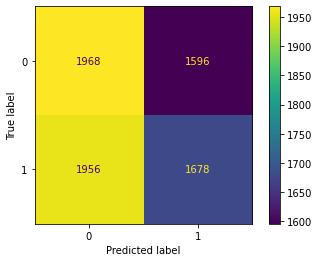

In [101]:
model.eval()
# Thêm confusion
pred_list = torch.Tensor([]).to(device)
ground_truth_list = torch.Tensor([]).to(device)

# Start
for batch in test_iterator:
    text,text_lengths = batch.text
    
    
    len_all = len(text_lengths)        
    fake_text = []
    fake_text_lengths = []
    fake_label = []
    for i in range(0,len_all):
        if text_lengths[i] != 0:
            fake_text.append(text[i].tolist())
            fake_text_lengths.append(text_lengths[i].item() )
            fake_label.append(batch.label[i].item())
    text = torch.Tensor(fake_text).long().to(device)
    text_lengths = torch.Tensor(fake_text_lengths).long().to(device)
    batch.label = torch.Tensor(fake_label).to(device)
    
    predictions = model(text,text_lengths).squeeze()
    #End
    
    # Thêm confusion
    pred_list = torch.cat( (pred_list, torch.round(torch.clone(predictions))   ))
    ground_truth_list = torch.cat ( (ground_truth_list,(torch.clone(batch.label))))

    loss = criterion(predictions,batch.label)
    test_loss_list = torch.cat((test_loss_list, torch.Tensor([loss.item()])))
        
    test_ground_truth = torch.clone(batch.label).cpu().detach().numpy()
    test_pred_round = torch.round(torch.clone(predictions)).cpu().detach().numpy()
        
    f1 = f1_score(test_ground_truth, test_pred_round, average="binary")
    test_f1 = torch.cat((test_f1, torch.Tensor([f1.item()])))
  
    acc = accuracy_score(test_ground_truth, test_pred_round)
    test_acc = torch.cat((test_acc, torch.Tensor([acc.item()])))
 
    precision = precision_score(test_ground_truth, test_pred_round, average="binary")
    test_precision = torch.cat((test_precision, torch.Tensor([precision.item()])))

    recall = recall_score(test_ground_truth, test_pred_round, average="binary")
    test_recall = torch.cat((test_recall, torch.Tensor([recall.item()])))
#     break
# 1. Loss
mean_test_loss = torch.sum(test_loss_list) / test_loss_list.shape[0]
# 2. F1_score
mean_test_f1 = torch.sum(test_f1) / test_f1.shape[0]
# 3. Accuracy
mean_test_acc = torch.sum(test_acc) / test_acc.shape[0]
# 4. Precision
mean_test_precision = torch.sum(test_precision) / test_precision.shape[0]
 # 5. Recall
mean_test_recall = torch.sum(test_recall) / test_recall.shape[0]

print(f"Test loss: {mean_test_loss}")
print(f"Test acc: {mean_test_acc}")
print(f"Test precision: {mean_test_precision}")
print(f"Test recall: {mean_test_recall}")
print(f"Test f1: {mean_test_f1}")
print(f"=======================================================================")
target_names = ['class 0', 'class 1']
ff = classification_report(ground_truth_list.cpu().detach().numpy(), pred_list.cpu().detach().numpy(), target_names = target_names)
print(ff)
confusion_matrix = metrics.confusion_matrix(ground_truth_list.cpu().detach().numpy(), pred_list.cpu().detach().numpy())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

**Diagram model train LSTM**

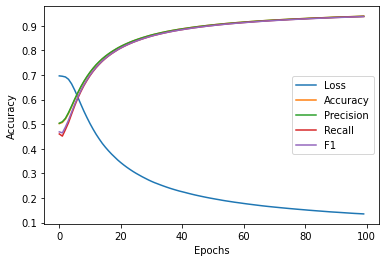

In [102]:
plt.plot(epochs_time, epoch_train_loss, label="Loss")
plt.plot(epochs_time, epoch_train_acc, label="Accuracy")
plt.plot(epochs_time, epoch_train_precision, label="Precision")
plt.plot(epochs_time, epoch_train_recall, label="Recall")
plt.plot(epochs_time, epoch_train_f1, label="F1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

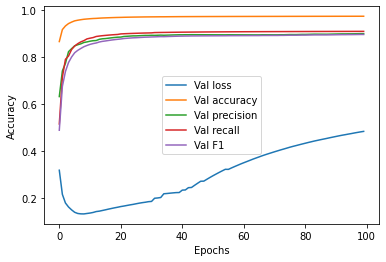

In [44]:
# plt.plot(epochs_time, epoch_val_loss, label="Val loss")
# plt.plot(epochs_time, epoch_val_acc, label="Val accuracy")
# plt.plot(epochs_time, epoch_val_precision, label="Val precision")
# plt.plot(epochs_time, epoch_val_recall, label="Val recall")
# plt.plot(epochs_time, epoch_val_f1, label="Val F1")
# plt.ylabel("Accuracy")
# plt.xlabel("Epochs")
# plt.legend()
# plt.show()

In [115]:
torch.save(model.state_dict(), 'model_text_lstm_classification.pth')

In [114]:
text = "món ăn không  đẹp bù lại thì ngon và đầy màu sắc"
text = tokenize_vie(text)
transform_text= torch.Tensor([ TEXT.vocab.stoi[i] for i in text]).long()
model.eval()
re = model(transform_text.unsqueeze(0),torch.Tensor([len(text)]))
print(re)
if re[0][0] < 0.5:
    print("Tích cực")
else:
    print("Tiêu cực")


tensor([[2.3389e-06]], grad_fn=<SigmoidBackward>)
Tích cực


In [116]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super(PositionalEncoding,self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return x

In [126]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int):
        super(TransformerModel,self).__init__()
        self.embedding = nn.Embedding(ntoken, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, nlayers)
        
        self.linear_1 = nn.Linear(d_hid, 16)
        self.batch_norm_1 = nn.BatchNorm1d(16)

        self.linear_2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, src) :
        h = self.embedding(src) 
        h = self.pos_encoder(h)
        h = self.transformer_encoder(h)
        h = F.leaky_relu(h, 0.01)
        h  = torch.mean(h, dim=1)
        
        h = self.linear_1(h)
        h = F.relu(h)
        h = self.batch_norm_1(h)
        
        h = self.linear_2(h)
        h = F.sigmoid(h)
        return h
    
SIZE_OF_VOCAB = len(TEXT.vocab)
EMBEDDING_DIM = 32
NUM_HEADS = 8
NUM_LAYERS = 6
model = TransformerModel(SIZE_OF_VOCAB, EMBEDDING_DIM, NUM_HEADS, 32, NUM_LAYERS)
model.to(device)
# criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.BCELoss().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.01)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

464417


In [ ]:
epochs_time = torch.Tensor([])

train_loss_list, val_loss_list, test_loss_list = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_loss, epoch_val_loss, epoch_test_loss = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_f1, val_f1, test_f1 = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_f1, epoch_val_f1, epoch_test_f1 = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_acc, val_acc, test_acc = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_acc, epoch_val_acc, epoch_test_acc = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_precision, val_precision, test_precision = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_precision, epoch_val_precision, epoch_test_precision = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

train_recall, val_recall, test_recall = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
epoch_train_recall, epoch_val_recall, epoch_test_recall = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])

for epoch in range(100):
    model.train()
    
    # Start
    for batch in train_iterator:      
        optimizer.zero_grad()
        text,text_lengths = batch.text
        len_all = len(text_lengths)        
        
        fake_text = []
#         fake_text_lengths = []
        fake_label = []

        for i in range(0,len_all):
            if text_lengths[i] != 0:
                fake_text.append(text[i].tolist())
#                 fake_text_lengths.append(text_lengths[i].item() )
                fake_label.append(batch.label[i].item())
        
        text = torch.Tensor(fake_text).long().to(device)
#         text_lengths = torch.Tensor(fake_text_lengths).long().to(device)
        batch.label = torch.Tensor(fake_label).to(device)

        predictions = model(text).squeeze()
        
        loss = criterion(predictions,batch.label)

        train_loss_list = torch.cat((train_loss_list, torch.Tensor([loss.item()])))
        
        train_pred_round = torch.round(torch.clone(predictions)).cpu().detach().numpy()
        train_ground_truth = torch.clone(batch.label).cpu().detach().numpy()
    
        f1 = f1_score(train_ground_truth, train_pred_round, average="binary")
        train_f1 = torch.cat((train_f1, torch.Tensor([f1.item()])))
  
        acc = accuracy_score(train_ground_truth, train_pred_round)
        train_acc = torch.cat((train_acc, torch.Tensor([acc.item()])))
 
        precision = precision_score(train_ground_truth, train_pred_round, average="binary")
        train_precision = torch.cat((train_precision, torch.Tensor([precision.item()])))

        recall = recall_score(train_ground_truth, train_pred_round, average="binary")
        train_recall = torch.cat((train_recall, torch.Tensor([recall.item()])))

        loss.backward()
        optimizer.step()
  
#     model.eval()
#     # Start
#     for batch in val_iterator:
#         text,text_lengths = batch.text
#         text = text.to(device)
#         text_lengths = text_lengths.to(device)
#         batch.label = batch.label.to(device)
#         predictions = model(text,text_lengths).squeeze()
#         loss = criterion(predictions,batch.label)
#         # End
        
#         val_loss_list = torch.cat((val_loss_list, torch.Tensor([loss.item()])))
        
#         val_ground_truth = torch.clone(batch.label).cpu().detach().numpy()
#         val_pred_round = torch.round(torch.clone(predictions)).cpu().detach().numpy()
        
#         f1 = f1_score(val_ground_truth, val_pred_round, average="binary")
#         val_f1 = torch.cat((val_f1, torch.Tensor([f1.item()])))
  
#         acc = accuracy_score(val_ground_truth, val_pred_round)
#         val_acc = torch.cat((val_acc, torch.Tensor([acc.item()])))
 
#         precision = precision_score(val_ground_truth, val_pred_round, average="binary")
#         val_precision = torch.cat((val_precision, torch.Tensor([precision.item()])))

#         recall = recall_score(val_ground_truth, val_pred_round, average="binary")
#         val_recall = torch.cat((val_recall, torch.Tensor([recall.item()])))
    
    epochs_time = torch.cat((epochs_time, torch.Tensor([epoch])))
    # 1. Loss
    mean_train_loss = torch.sum(train_loss_list) / train_loss_list.shape[0]
    epoch_train_loss = torch.cat((epoch_train_loss, torch.Tensor([mean_train_loss.item()])))
    
#     mean_val_loss = torch.sum(val_loss_list) / val_loss_list.shape[0]
#     epoch_val_loss = torch.cat((epoch_val_loss, torch.Tensor([mean_val_loss.item()])))
    
    # 2. F1_score
    mean_train_f1 = torch.sum(train_f1) / train_f1.shape[0]
    epoch_train_f1 = torch.cat((epoch_train_f1, torch.Tensor([mean_train_f1.item()])))
    
#     mean_val_f1 = torch.sum(val_f1) / val_f1.shape[0]
#     epoch_val_f1 = torch.cat((epoch_val_f1, torch.Tensor([mean_val_f1.item()])))

    # 3. Accuracy
    mean_train_acc = torch.sum(train_acc) / train_acc.shape[0]
    epoch_train_acc = torch.cat((epoch_train_acc, torch.Tensor([mean_train_acc.item()])))
    
#     mean_val_acc = torch.sum(val_acc) / val_acc.shape[0]
#     epoch_val_acc = torch.cat((epoch_val_acc, torch.Tensor([mean_val_acc.item()])))

    # 4. Precision
    mean_train_precision = torch.sum(train_precision) / train_precision.shape[0]
    epoch_train_precision = torch.cat((epoch_train_precision, torch.Tensor([mean_train_precision.item()])))

#     mean_val_precision = torch.sum(val_precision) / val_precision.shape[0]
#     epoch_val_precision = torch.cat((epoch_val_precision, torch.Tensor([mean_val_precision.item()])))

    # 5. Recall
    mean_train_recall = torch.sum(train_recall) / train_recall.shape[0]
    epoch_train_recall = torch.cat((epoch_train_recall, torch.Tensor([mean_train_recall.item()])))
    
#     mean_val_recall = torch.sum(val_recall) / val_recall.shape[0]
#     epoch_val_recall = torch.cat((epoch_val_recall, torch.Tensor([mean_val_recall.item()])))
    
#     print(f"Epochs: {epoch}, loss: {mean_train_loss}, val loss: {mean_val_loss}")
#     print(f"Accuracy acc: {mean_train_acc}, val accuracy acc: {mean_val_acc}")
#     print(f"Accuracy precision: {mean_train_precision}, val accuracy precision: {mean_val_precision}")
#     print(f"Accuracy recall: {mean_train_recall}, val accuracy recall: {mean_val_recall}")
#     print(f"Accuracy f1: {mean_train_f1}, val accuracy f1: {mean_val_f1}")
    
    print(f"Epochs: {epoch}, loss: {mean_train_loss}")
    print(f"Accuracy acc: {mean_train_acc}")
    print(f"Accuracy precision: {mean_train_precision}")
    print(f"Accuracy recall: {mean_train_recall}")
    print(f"Accuracy f1: {mean_train_f1}")
    print(f"=======================================================================")

Epochs: 0, loss: 0.6946369409561157
Accuracy acc: 0.4956475794315338
Accuracy precision: 0.4949958026409149
Accuracy recall: 0.493733674287796
Accuracy f1: 0.46400588750839233
Epochs: 1, loss: 0.6941691040992737
Accuracy acc: 0.4964049458503723
Accuracy precision: 0.48694032430648804
Accuracy recall: 0.5061177611351013
Accuracy f1: 0.4575170576572418
Epochs: 2, loss: 0.6939913034439087
Accuracy acc: 0.4979148507118225
Accuracy precision: 0.47812017798423767
Accuracy recall: 0.5069481730461121
Accuracy f1: 0.45457038283348083
Epochs: 3, loss: 0.6938440799713135
Accuracy acc: 0.4984094202518463
Accuracy precision: 0.46608853340148926
Accuracy recall: 0.4815059304237366
Accuracy f1: 0.43540751934051514
Epochs: 4, loss: 0.6937536001205444
Accuracy acc: 0.49838683009147644
Accuracy precision: 0.4533989429473877
Accuracy recall: 0.4922918975353241
Accuracy f1: 0.42606478929519653
Epochs: 5, loss: 0.6936725378036499
Accuracy acc: 0.497910737991333
Accuracy precision: 0.4265250861644745
Accura

In [ ]:
model.eval()
# Thêm confusion
pred_list = torch.Tensor([]).to(device)
ground_truth_list = torch.Tensor([]).to(device)

# Start
for batch in test_iterator:
    text,text_lengths = batch.text
    
    
    len_all = len(text_lengths)        
    fake_text = []
    fake_text_lengths = []
    fake_label = []
    for i in range(0,len_all):
        if text_lengths[i] != 0:
            fake_text.append(text[i].tolist())
            fake_text_lengths.append(text_lengths[i].item() )
            fake_label.append(batch.label[i].item())
    text = torch.Tensor(fake_text).long().to(device)
    text_lengths = torch.Tensor(fake_text_lengths).long().to(device)
    batch.label = torch.Tensor(fake_label).to(device)
    
    predictions = model(text,text_lengths).squeeze()
    #End
    
    # Thêm confusion
    pred_list = torch.cat( (pred_list, torch.round(torch.clone(predictions))   ))
    ground_truth_list = torch.cat ( (ground_truth_list,(torch.clone(batch.label))))

    loss = criterion(predictions,batch.label)
    test_loss_list = torch.cat((test_loss_list, torch.Tensor([loss.item()])))
        
    test_ground_truth = torch.clone(batch.label).cpu().detach().numpy()
    test_pred_round = torch.round(torch.clone(predictions)).cpu().detach().numpy()
        
    f1 = f1_score(test_ground_truth, test_pred_round, average="binary")
    test_f1 = torch.cat((test_f1, torch.Tensor([f1.item()])))
  
    acc = accuracy_score(test_ground_truth, test_pred_round)
    test_acc = torch.cat((test_acc, torch.Tensor([acc.item()])))
 
    precision = precision_score(test_ground_truth, test_pred_round, average="binary")
    test_precision = torch.cat((test_precision, torch.Tensor([precision.item()])))

    recall = recall_score(test_ground_truth, test_pred_round, average="binary")
    test_recall = torch.cat((test_recall, torch.Tensor([recall.item()])))
#     break
# 1. Loss
mean_test_loss = torch.sum(test_loss_list) / test_loss_list.shape[0]
# 2. F1_score
mean_test_f1 = torch.sum(test_f1) / test_f1.shape[0]
# 3. Accuracy
mean_test_acc = torch.sum(test_acc) / test_acc.shape[0]
# 4. Precision
mean_test_precision = torch.sum(test_precision) / test_precision.shape[0]
 # 5. Recall
mean_test_recall = torch.sum(test_recall) / test_recall.shape[0]

print(f"Test loss: {mean_test_loss}")
print(f"Test acc: {mean_test_acc}")
print(f"Test precision: {mean_test_precision}")
print(f"Test recall: {mean_test_recall}")
print(f"Test f1: {mean_test_f1}")
print(f"=======================================================================")
target_names = ['class 0', 'class 1']
ff = classification_report(ground_truth_list.cpu().detach().numpy(), pred_list.cpu().detach().numpy(), target_names = target_names)
print(ff)
confusion_matrix = metrics.confusion_matrix(ground_truth_list.cpu().detach().numpy(), pred_list.cpu().detach().numpy())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
plt.plot(epochs_time, epoch_train_loss, label="Loss")
plt.plot(epochs_time, epoch_train_acc, label="Accuracy")
plt.plot(epochs_time, epoch_train_precision, label="Precision")
plt.plot(epochs_time, epoch_train_recall, label="Recall")
plt.plot(epochs_time, epoch_train_f1, label="F1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
text = "món ăn không  đẹp bù lại thì ngon và đầy màu sắc"
text = tokenize_vie(text)
transform_text= torch.Tensor([ TEXT.vocab.stoi[i] for i in text]).long()
model.eval()
re = model(transform_text.unsqueeze(0),torch.Tensor([len(text)]))
print(re)
if re[0][0] < 0.5:
    print("Tích cực")
else:
    print("Tiêu cực")
